In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [23]:
import os
import pandas as pd
import numpy as np
import math

import sys
sys.path.append("../..")
from src.load_datasets import load_dataset, load_rankings, load_train_data
import src.evaluate_regression
import time

# From example
import src.encoder_utils as eu
import src.evaluate_regression as er
import src.load_datasets as ld
import src.pairwise_utils as pu

from category_encoders import OneHotEncoder
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.multioutput import MultiOutputClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier

import xgboost
import catboost 
import lightgbm

# Example

- With CV
- Without preprocessing

In [3]:
# Define variables for ranking
factors = ["dataset", "model", "tuning", "scoring"]
new_index = "encoder"
target = "rank"

In [4]:
df_train = ld.load_dataset("../../data/raw/dataset_rank_train.csv")

if "cv_score" in df_train.columns:
    df_train = df_train.drop("cv_score", axis=1)

Loading data from '../../data/raw/dataset_rank_train.csv' ...


In [5]:
df_train = pd.pivot(df_train, index=factors, columns="encoder", values="rank").reset_index()
X_train = df_train[factors]
y_train = df_train.drop(factors, axis=1)
y_train = y_train.fillna(np.max(y_train))

### Preprocessing

- Do not preprocess (embed) the encoder features (because it is not present in this task)

In [6]:
import src.encoding
from src.feature_engineering import normalize_train_data, normalize_test_data
from src.meta_information import add_dataset_meta_information
from src.data_cleaning import drop_pearson_correlated_features

In [7]:
base_df = df_train[factors].copy()
print(base_df.columns)

Index(['dataset', 'model', 'tuning', 'scoring'], dtype='object', name='encoder')


In [8]:
# OHE encoding 
X_train, ohe = src.encoding.ohe_encode_train_data(X_train=X_train,
                                                  cols_to_encode=["model", "tuning", "scoring"],
                                                  verbosity=2)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the train data ...


In [9]:
base_df_mod = src.encoding.ohe_encode_test_data(X_test=base_df,
                                                cols_to_encode=["model", "tuning", "scoring"],
                                                ohe=ohe, 
                                                verbosity=2)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the test data ...


In [10]:
X_train = add_dataset_meta_information(df=X_train,
                                       path_to_meta_df="../../data/preprocessed/dataset_agg.csv",
                                       nan_threshold=0.5,
                                       replacing_strategy="median")

In [11]:
X_train, _ = drop_pearson_correlated_features(train_data=X_train, 
                                              test_data=None, 
                                              threshold=0.7, 
                                              verbosity=2)

Drop pearson correlated features with threshold 0.7...
Filter correlated features


### Modelling

In [13]:
cv_indices = src.evaluate_regression.custom_cross_validated_indices(pd.concat([X_train, y_train], axis=1), 
                                                                    list(X_train.columns), 
                                                                    list(y_train.columns),  #target 
                                                                    n_splits=5, 
                                                                    shuffle=True, 
                                                                    random_state=1444)

In [26]:
# Define models
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
dt = DecisionTreeClassifier(random_state=42)
et = ExtraTreeClassifier(random_state=42)
ets = ExtraTreesClassifier(random_state=42, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
svc = LinearSVC(random_state=42)  
rnc = RadiusNeighborsClassifier(n_jobs=-1, radius=5)
rid = RidgeClassifier(random_state=42)
#mlp = MLPClassifier(random_state=42, max_iter=2000)  # Increased max iter due to non-convergence exception in last run
xgb = xgboost.XGBClassifier(random_state=42, n_jobs=-1)
lgbm = lightgbm.LGBMClassifier(random_state=42, n_jobs=-1)
cb = catboost.CatBoostClassifier(random_seed=42,
                                 loss_function='MultiLogloss',
                                 eval_metric='HammingLoss',
                                 class_names=list(y_train.columns), 
                                 verbose=0
)

# Define list of models
models = [dt, rf, et, ets, knn, rid, lgbm] 

# Define dicts for results of each model
scores = {str(model).split('(')[0] : []
             for model in models}
fit_times = {str(model).split('(')[0] : []
             for model in models}
predict_times = {str(model).split('(')[0] : []
             for model in models}

In [27]:
for model in models:
    print(f"{model}")
    
    tmp_scores = []
    tmp_train_time = []
    tmp_pred_time = []
    for fold in cv_indices:
        # Get train and test data for current split
        X_tr = X_train.iloc[fold[0]].copy()
        X_te = X_train.iloc[fold[1]].copy()
        y_tr = y_train.iloc[fold[0]].copy()
        y_te = y_train.iloc[fold[1]].copy()
        
        # Get data for evaluation
        base_df_test_slice = base_df.iloc[fold[1]]
        
        # Setup pipeline / model
        # Default pipeline
        pipeline = Pipeline([("scaler", MinMaxScaler()), ("model", model)])
        # Multioutput
        if str(model).split('(')[0] in ["LGBMClassifier", "XGBClassifier", "RidgeClassifier"]:
            pipeline = Pipeline([("scaler", MinMaxScaler()), ("model", MultiOutputClassifier(model))])
        
        # Train 
        start_train_time = time.time()
        fitted_model = pipeline.fit(X_tr, y_tr)
        end_train_time = time.time()
        tmp_train_time.append(end_train_time - start_train_time)
        
        # Predict
        start_pred_time = time.time()
        y_pred = pd.DataFrame(fitted_model.predict(X_te), columns=y_tr.columns, index=X_te.index)
        end_pred_time = time.time()
        tmp_pred_time.append(end_pred_time - start_pred_time)
        
        df_pred = pd.merge(pd.concat([base_df_test_slice, y_te], axis=1).melt(id_vars=factors, value_name="rank").dropna(axis=0),
                           pd.concat([base_df_test_slice, y_pred], axis=1).melt(id_vars=factors, value_name="rank_pred"),
                           on=factors+["encoder"], how="left")

        rankings_test = er.get_rankings(df_pred.drop_duplicates(), factors=factors, new_index=new_index, target="rank")
        rankings_pred = er.get_rankings(df_pred.drop_duplicates(), factors=factors, new_index=new_index, target="rank_pred")
    
        tmp_scores.append(er.average_spearman(rankings_test, rankings_pred))
    
    # Add score and std to dicts for plots
    m = str(model).split('(')[0]
    scores[m] = tmp_scores
    predict_times[m] = tmp_pred_time
    fit_times[m] = tmp_train_time
    
    # Print scores
    print(f"Avg Spearman: {round(np.mean(scores[m]), 4)} +/- {round(np.std(scores[m]), 4)}")
    print("")

DecisionTreeClassifier(random_state=42)
Avg Spearman: 0.6884 +/- 0.0335

RandomForestClassifier(n_jobs=-1, random_state=42)
Avg Spearman: 0.6883 +/- 0.0257

ExtraTreeClassifier(random_state=42)
Avg Spearman: 0.6158 +/- 0.024

ExtraTreesClassifier(n_jobs=-1, random_state=42)
Avg Spearman: 0.7372 +/- 0.0202

KNeighborsClassifier(n_jobs=-1)
Avg Spearman: 0.1613 +/- 0.0082

RidgeClassifier(random_state=42)
Avg Spearman: 0.2489 +/- 0.0184

LGBMClassifier(random_state=42)
Avg Spearman: 0.6307 +/- 0.0104



# Plots

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
sns.set_theme(style="whitegrid")
#sns.set_palette(palette="Set2")
sns.set_palette(palette="Paired")
# set seed
np.random.seed(7)

In [29]:
df_plot = pd.DataFrame(data=scores).T

ms = []
ss = []
fs = []
tt = []
pt = []

# Iterate over models
for m in scores.keys():
    # Iterate over folds
    for f in range(5):
        ms.append(m)
        fs.append(f)
        ss.append(scores[m][f])
        pt.append(predict_times[m][f])
        tt.append(fit_times[m][f])

data = {
    "model": ms,
    "fold": fs,
    "score": ss,
    "pred_time": pt,
    "train_time": tt
}
#print(ms)
df_plot = pd.DataFrame(data=data)
#df_plot

### Average spearman

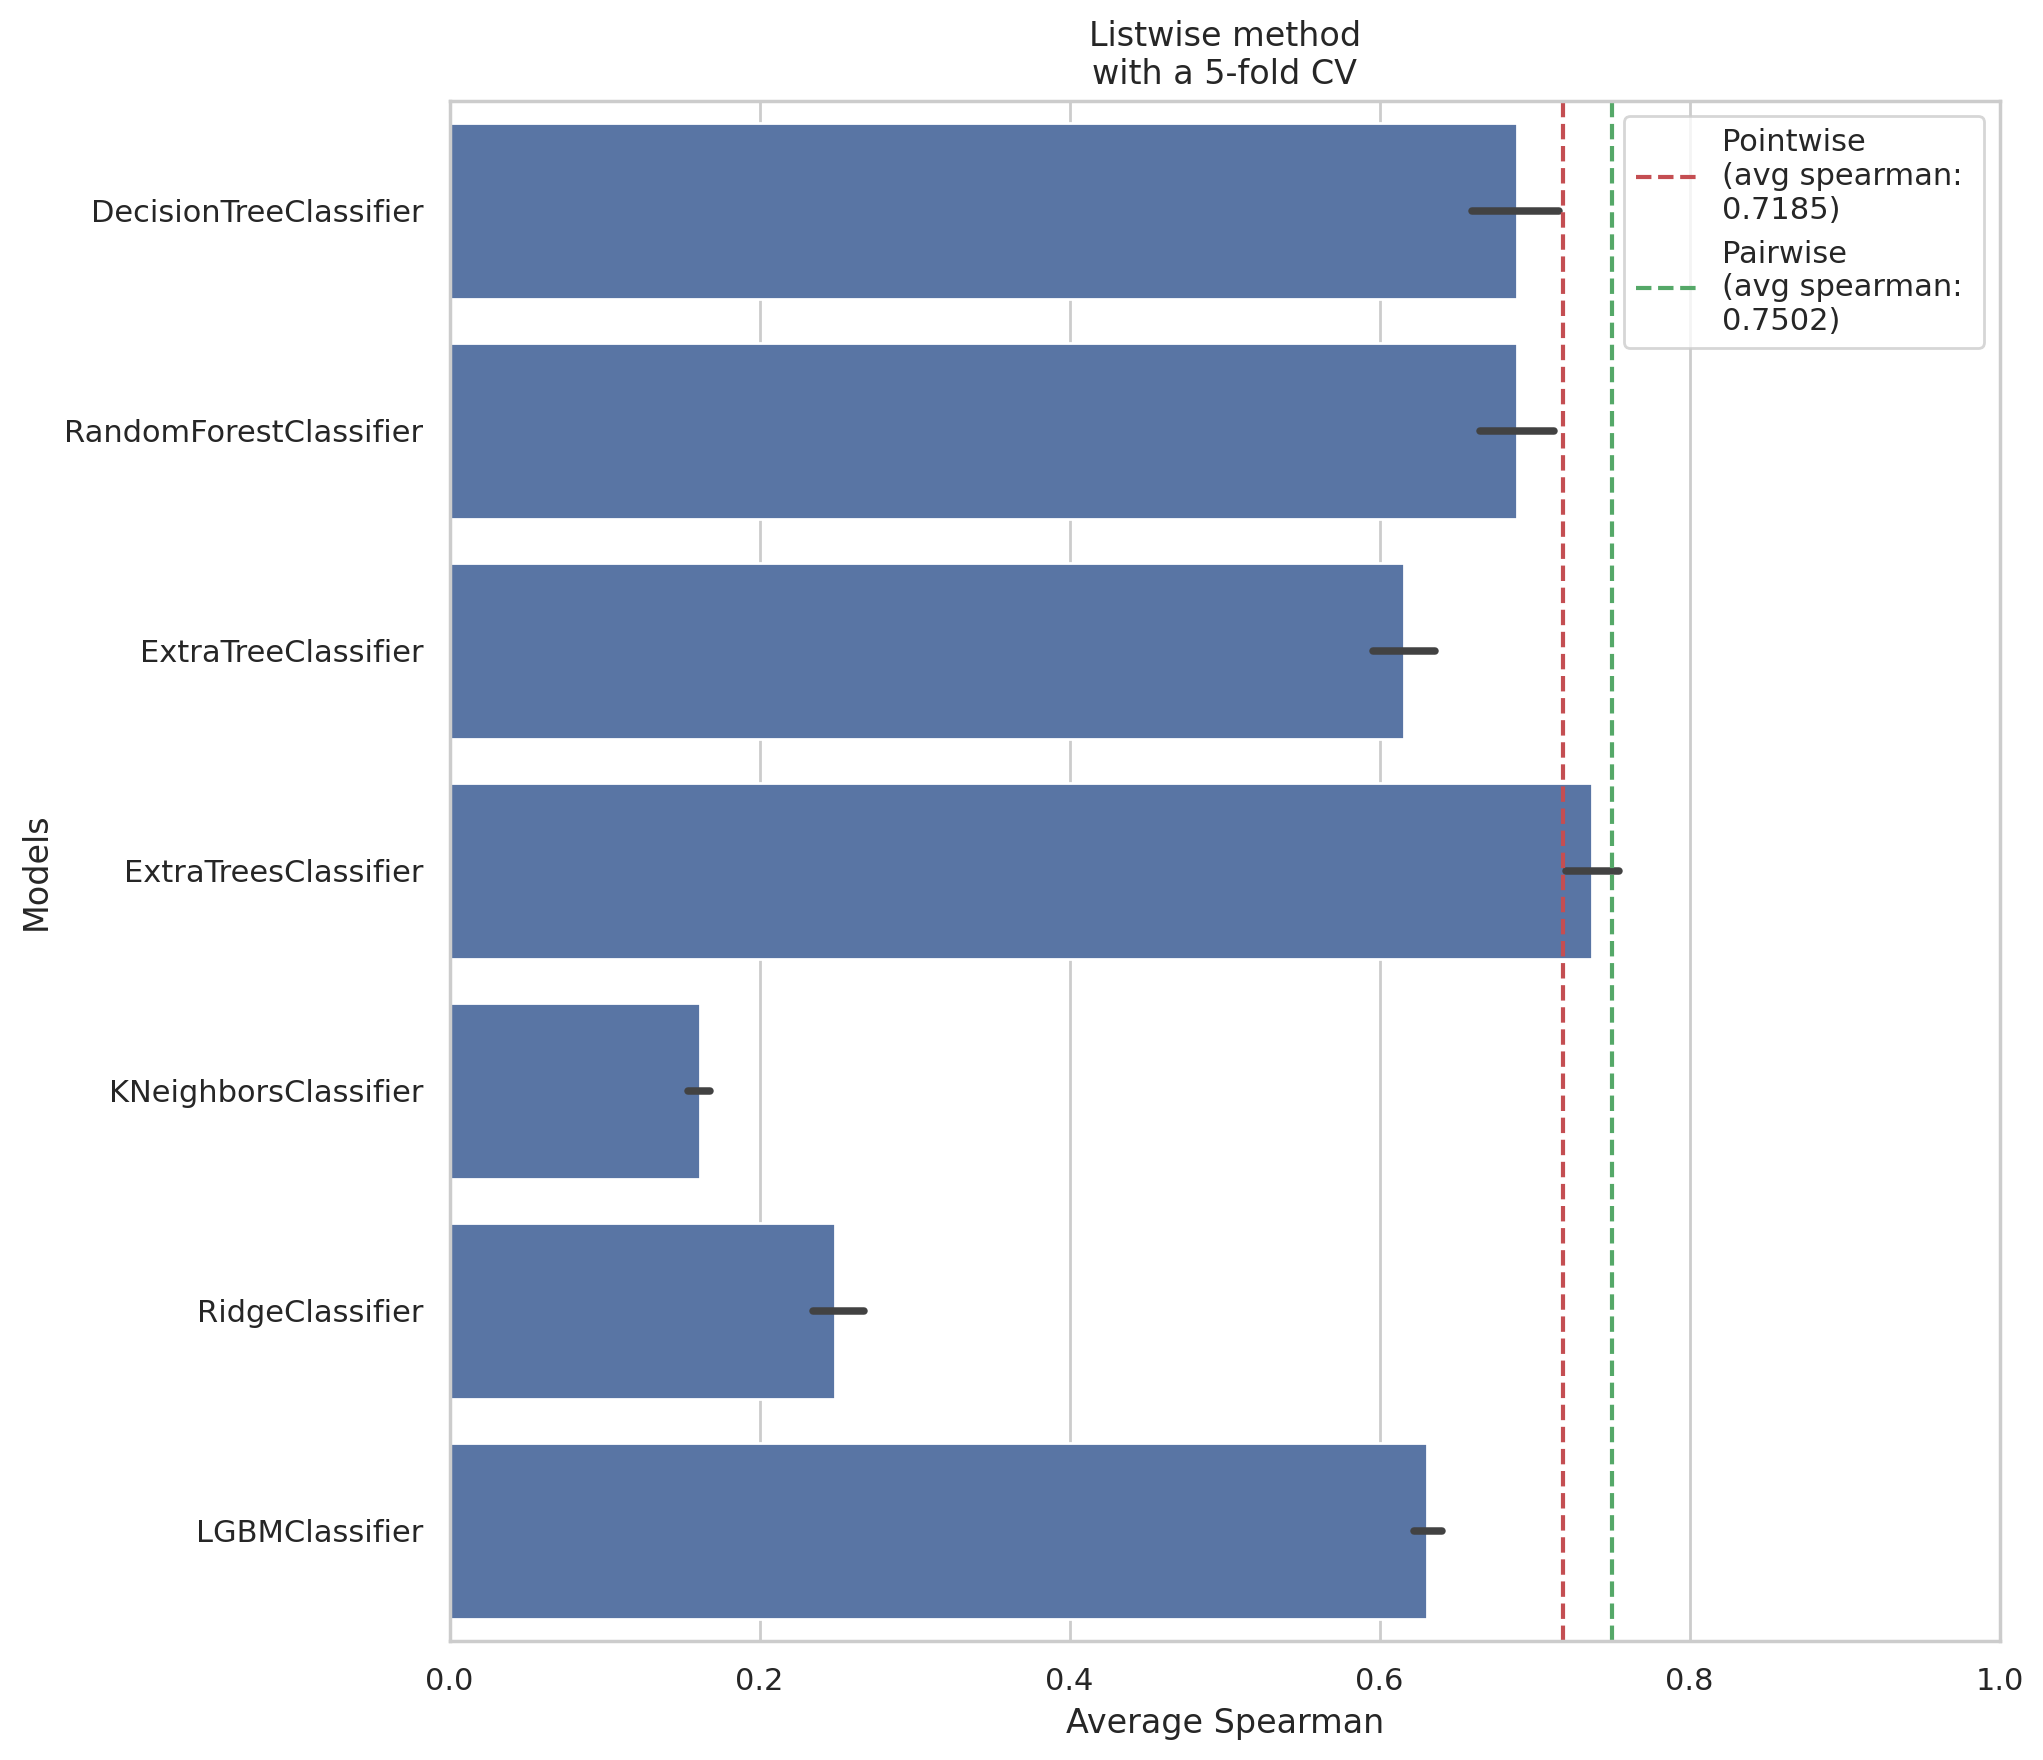

In [34]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, y="model", x="score", ax=axes, color="b")
plot.axvline(0.7185, color='r', ls='--', label='Pointwise \n(avg spearman: \n0.7185)')
plot.axvline(0.7502, color='g', ls='--', label='Pairwise \n(avg spearman: \n0.7502)')
plot.set(title="Listwise method\nwith a 5-fold CV")
plot.set_xlim([0.0, 1.0])
plot.legend(loc='upper right')

plot.set_ylabel("Models")
plot.set_xlabel("Average Spearman")

# Rotate items on x axis
#for item in axes.get_xticklabels():
#        item.set_rotation(90)

# Save figures
#f = plot.get_figure()
#f.savefig("Model_evaluation_blue.png") 
#f.savefig("Model_evaluation_blue.svg")

### Fit time

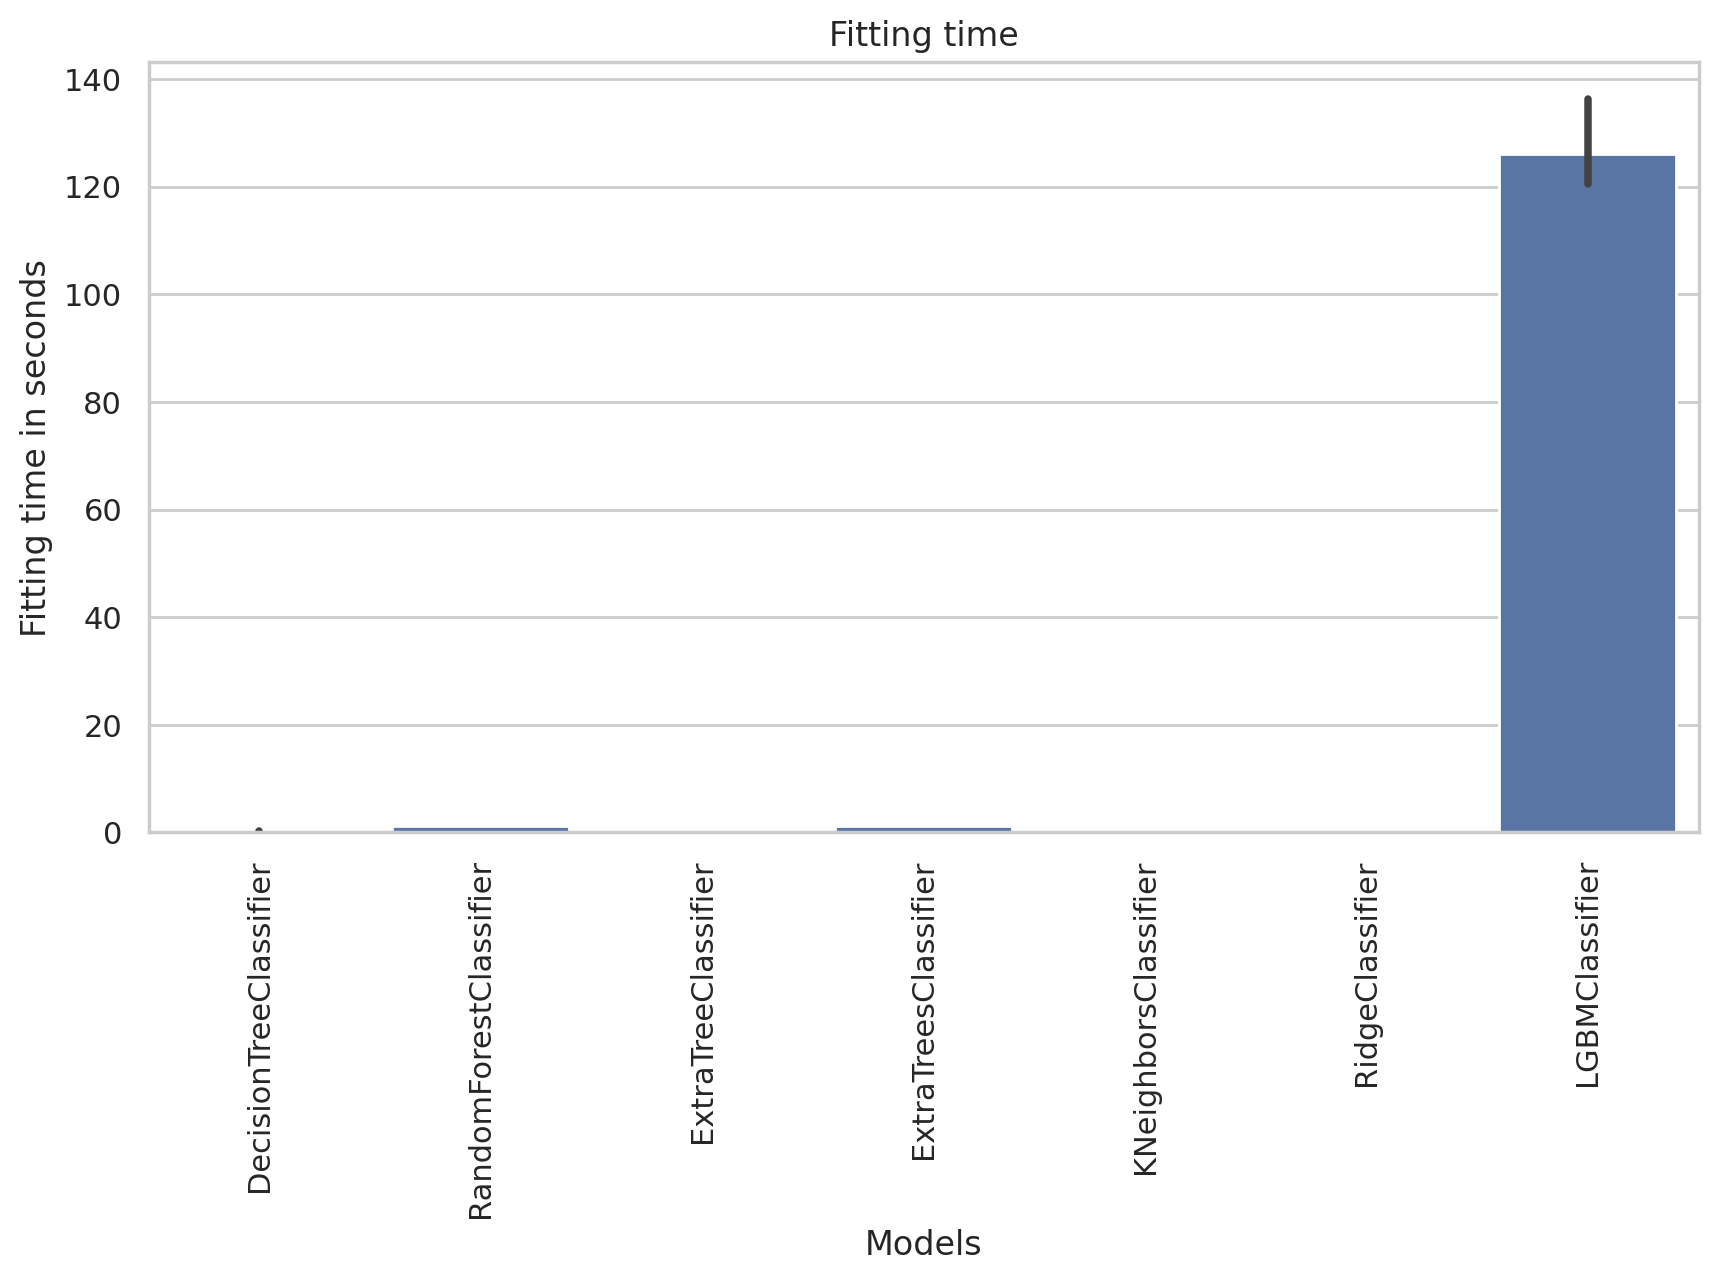

In [35]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, x="model", y="train_time", color="b")  # ax=axes, 
#plot.axhline(0.7185, color='r', ls='--', label='Baseline model (avg spearman: 0.7185)')
plot.set(title="Fitting time")
#plot.set_ylim([0.0, 1.0])
#plot.legend()

plot.set_xlabel("Models")
plot.set_ylabel("Fitting time in seconds")

# Save figures
#f = plot.get_figure()
#f.savefig("Fitting_time_mako.png") 
#f.savefig("Fitting_time_mako.svg")

# Rotate items on x axis
for item in axes.get_xticklabels():
        item.set_rotation(90)

### Prediction time

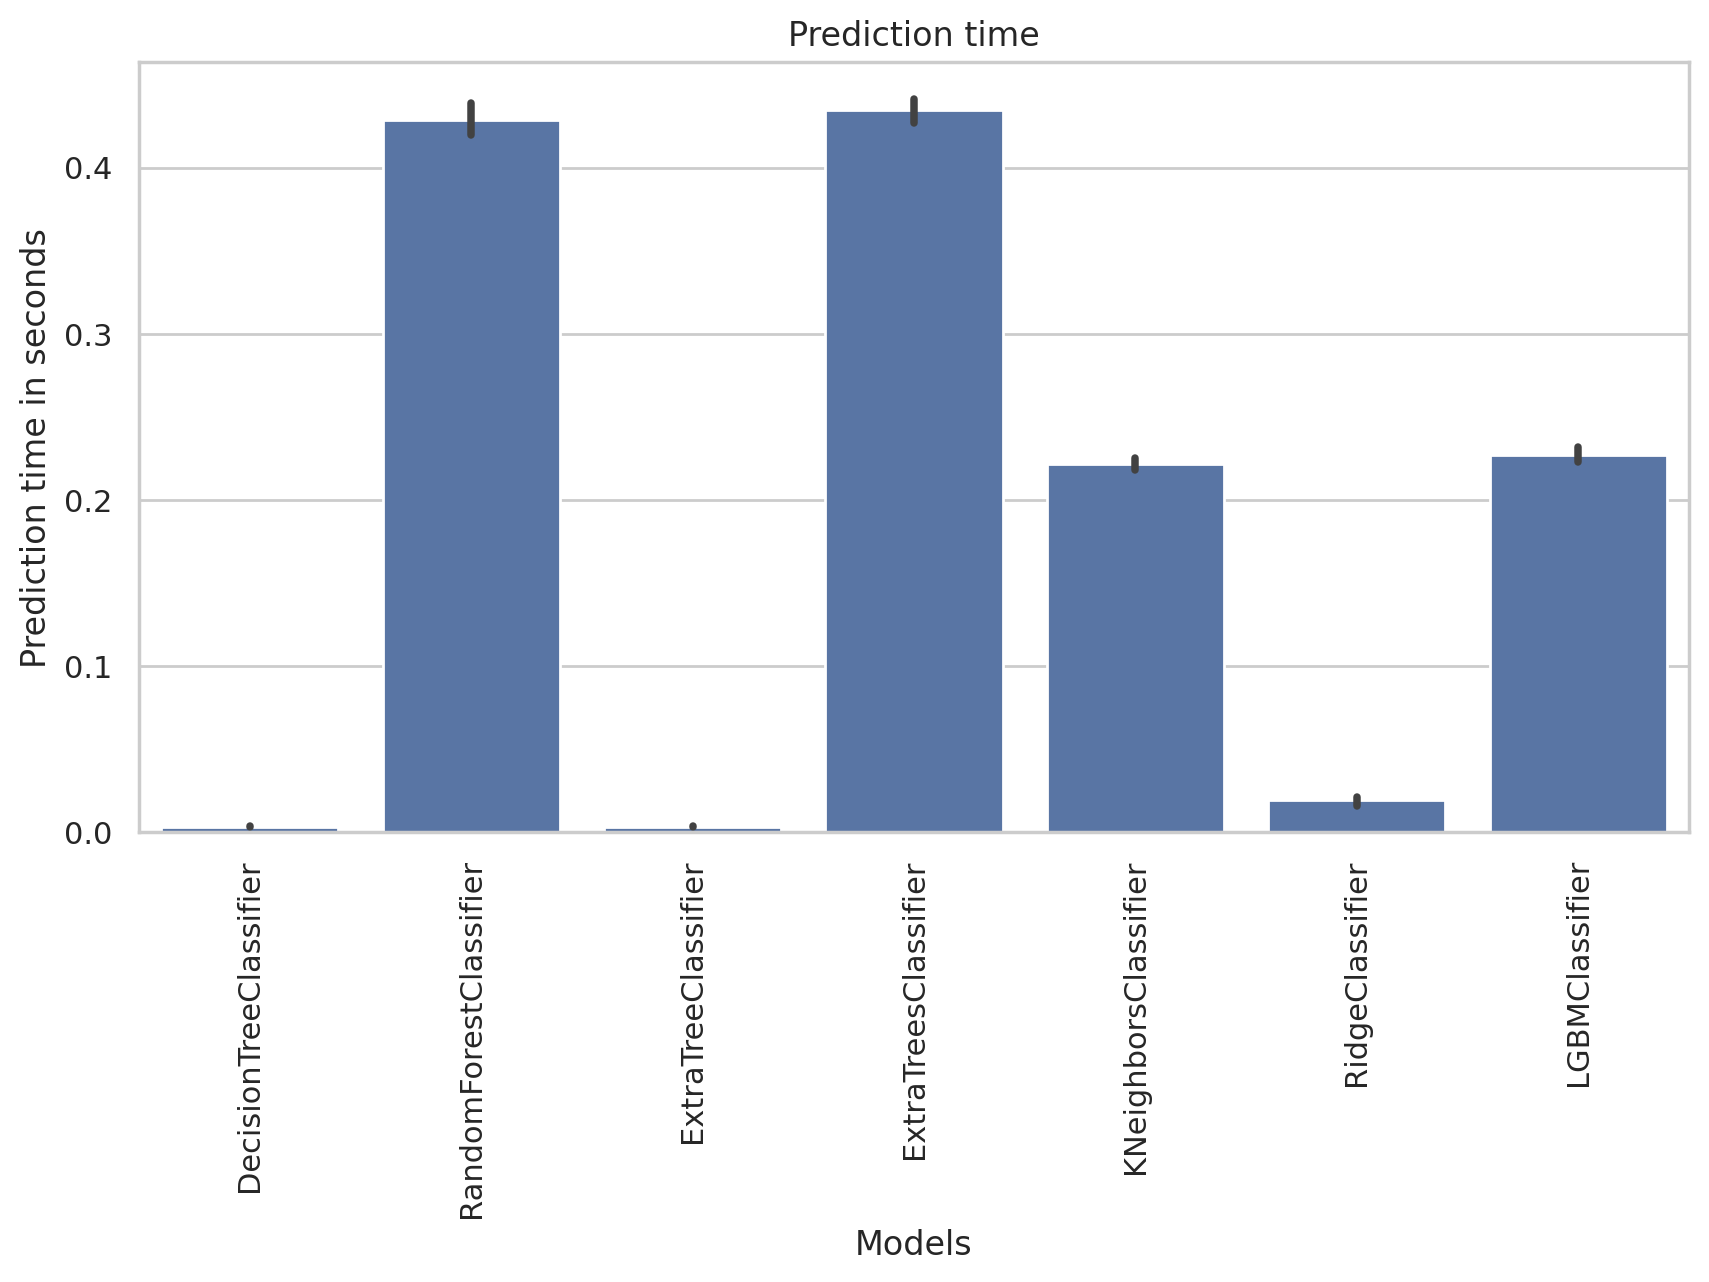

In [36]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, x="model", y="pred_time", color="b")  # ax=axes, 
#plot.axhline(0.7185, color='r', ls='--', label='Baseline model (avg spearman: 0.7185)')
plot.set(title="Prediction time")
#plot.set_ylim([0.0, 1.0])
#plot.legend()

plot.set_xlabel("Models")
plot.set_ylabel("Prediction time in seconds")

# Save figures
#f = plot.get_figure()
#f.savefig("Prediction_time_mako.png") 
#f.savefig("Prediction_time_mako.svg")

# Rotate items on x axis
for item in axes.get_xticklabels():
        item.set_rotation(90)